Cedric st122004

# An  end-to-end  deep  learning  approach  to  MI-EEG  signal  classification  for  BCIs

## Dataset and Model

1. Dataset is "EEG Motor Movement/Imagery Dataset" https://www.physionet.org/content/eegmmidb/1.0.0/
2. Model was built following this paper https://www.sciencedirect.com/science/article/abs/pii/S0957417418305359
3. Shallow CNN, Layer 1 convolves only on time axis, Layer 2 convolves on Channels

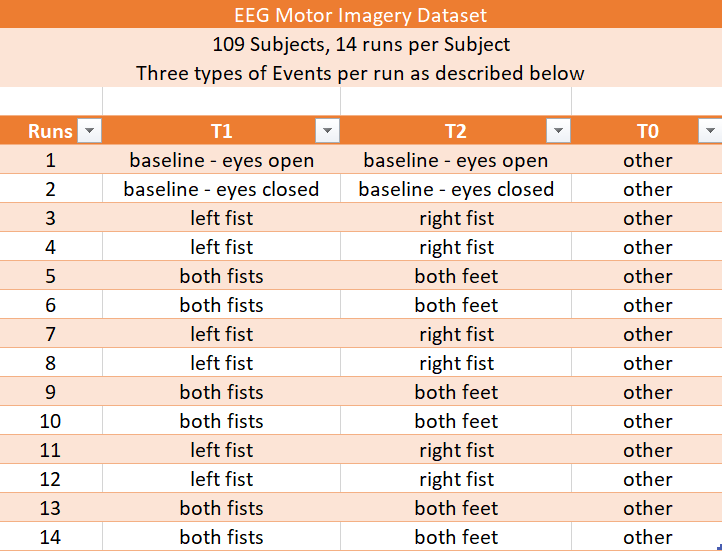

## 1. Load Dataset

In [1]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np

# from google.colab import drive

# Modeling and training packages
import torch
from torch import nn
import torch.optim as optim

# Data Preparation packages
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

#Configurations
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
dataset_path = '../models/data/'

Write the function to do read preprocess and any neccessary steps fot generating raw X and y

In [3]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=False, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=0., tmax=4.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1, channel_selection=False, channels=None):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            if channels is None:
                self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
            else:
                self.epochs = self.epochs.pick_channels(channels)
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False, channels=None):
        self.return_epochs(channel_selection=channel_selection, channels=channels)
        return self.epochs.get_data(), self.labels

To get X and y of Dataset, just simply implement the function

In [4]:
# Define subject list and runs number
subjects = [i for i in range(1, 61)]
runs = [3,7,11] # corresponds to closing/opening of left/right fists
# freq_select = (1,40)

# initialize dataset
eeg = motorImagery(dataset_path, subjects, runs)

# do filtering frequency
# eeg.apply_filter(freq=freq_select)

# gather X and y
# X, y = eeg.get_X_y(channel_selection=True, channels=['FC3','FC4'])
X, y = eeg.get_X_y(channel_selection=False, channels=['FC3','FC4'])

X.shape

Loading files at index: [2, 6, 10, 16, 20, 24, 30, 34, 38, 44, 48, 52, 58, 62, 66, 72, 76, 80, 86, 90, 94, 100, 104, 108, 114, 118, 122, 128, 132, 136, 142, 146, 150, 156, 160, 164, 170, 174, 178, 184, 188, 192, 198, 202, 206, 212, 216, 220, 226, 230, 234, 240, 244, 248, 254, 258, 262, 268, 272, 276, 282, 286, 290, 296, 300, 304, 310, 314, 318, 324, 328, 332, 338, 342, 346, 352, 356, 360, 366, 370, 374, 380, 384, 388, 394, 398, 402, 408, 412, 416, 422, 426, 430, 436, 440, 444, 450, 454, 458, 464, 468, 472, 478, 482, 486, 492, 496, 500, 506, 510, 514, 520, 524, 528, 534, 538, 542, 548, 552, 556, 562, 566, 570, 576, 580, 584, 590, 594, 598, 604, 608, 612, 618, 622, 626, 632, 636, 640, 646, 650, 654, 660, 664, 668, 674, 678, 682, 688, 692, 696, 702, 706, 710, 716, 720, 724, 730, 734, 738, 744, 748, 752, 758, 762, 766, 772, 776, 780, 786, 790, 794, 800, 804, 808, 814, 818, 822, 828, 832, 836]
Loading file #180/180: ../models/data/S060/S060R11.edfUsed Annotations descriptions: ['T1', 'T2']


(2688, 64, 641)

## 2. Data Preprocessing

In [5]:
# ## This is to prepare CNN data form (if implementing RNN, deactivate this cell)
X = X[:, np.newaxis,:,:]

In [6]:
print("X shape:", X.shape)
print("Y uniques:", np.unique(y))

X shape: (2688, 1, 64, 641)
Y uniques: [0 1]


In [7]:
X.shape, y.shape

((2688, 1, 64, 641), (2688,))

In [8]:
# normalize data in case we need it. However, this paper didn't so we will not use this
X_norm = (X-X.mean(axis=0))/X.std(axis=0)
X_norm.shape

(2688, 1, 64, 641)

In [9]:
## Preview data
# plt.plot(X[0, 0, 0,:])
# plt.title('Example eeg signal')
# plt.xlabel('time')
# plt.ylabel('amplitude ($\mu V$)' )
# plt.show()

In [10]:
# plt.plot(X[0, 0, 1,:])
# plt.title('Example eeg signal')
# plt.xlabel('time')
# plt.ylabel('amplitude ($\mu V$)' )
# plt.show()

Due to small value of EEG signal regarding to X. the values will be scaled up. Actually, the signal values are the micro volt ( 10−6 ) unit converted to volt. So that, the value should be rescaled to micro volt again to a scale of a unit of +1.0 or -1.0.

In [11]:
# X = X_norm
X = X *10000
X[0]

array([[[-0.24, -0.28, -0.33, ..., -0.39, -0.44, -0.67],
        [-0.08, -0.11, -0.29, ..., -0.45, -0.46, -0.65],
        [-0.04, -0.12, -0.37, ..., -0.46, -0.4 , -0.57],
        ...,
        [ 0.11,  0.04, -0.18, ..., -0.34, -0.26, -0.28],
        [-0.12, -0.2 , -0.32, ..., -0.38, -0.33, -0.25],
        [-0.09, -0.02, -0.05, ..., -0.59, -0.45, -0.39]]])

In [12]:
def Xy_dataloader(X_numpy, y_numpy, batch_size=32):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy).long()
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

Before Loading data into DataLoader, split X and y into train set and test (validation) set.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Load training set and test set for DataLoader

In [14]:
train_loader = Xy_dataloader(X_train, y_train, 64)
test_loader = Xy_dataloader(X_test, y_test, 64)

## 3. Modeling

In [15]:
from torch import nn
import torch.nn.functional as F

In [17]:
x = next(iter(train_loader))[0]
x.shape

torch.Size([64, 1, 64, 641])

In [18]:
class ConvNet3(nn.Module):
    
    def __init__(self, input_channels, output_channels): 
        super().__init__()
        
        self.input_channels = input_channels
        self.output_channels = output_channels
        
        # Layer 1 convolves on the time axis
        output1 = 40
        self.layer1 = nn.Sequential(nn.Conv2d(input_channels, output1, kernel_size=(1, 30)),
                                    nn.ReLU(),
#                                     nn.Dropout2d(p=0.2) # paper mentions not using dropout
                                   )
        
        
        # Layer 2 convolves on the channel axis
        output2 = 40
        self.layer2 = nn.Sequential(nn.Conv2d(output1, output2, kernel_size=(2, 1)),
                                    nn.ReLU(),
#                                     nn.Dropout(p=0.2), # paper mentions not using dropout
                                    nn.AvgPool2d(kernel_size=(1, 15)))
        
        self.fc1 = nn.Linear(100800, 80)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.layer1(x)
        
        x = self.layer2(x)
        
        x = x.reshape(x.size(0), -1)
        
        x = self.fc1(x)
        
        x = F.softmax(x, dim=1)
        
        return x
    
    

## 4. Training

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('pytorch is using: ', device)

pytorch is using:  cuda


Define Optimizer and Loss function

In [20]:
model = ConvNet3(1, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

### Training function

In [21]:
def train_model(model, train_dataloader, valid_dataloader, 
                epochs, criterion, optimizer, print_epoch=1000):
    
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_valid = []
    
    for i in range(1, epochs+1):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        correct = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        acc_train.append(100 * correct / len(train_dataloader.dataset))
        loss_train.append(epoch_loss/len(train_dataloader))
        # loss_train.append(epoch_loss)
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        correct = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
        
        acc_valid.append(100 * correct / len(valid_dataloader.dataset))
        loss_valid.append(epoch_loss/len(valid_dataloader))
        # loss_valid.append(epoch_loss)
        
        # ================= PRINT ===========================
        if i % print_epoch == 0 :
            clear_output(wait=True)
            print(f'epoch {i}/{epochs} train loss: {np.round(loss_train[-1],5)} train acc: {np.round(acc_train[-1],5)} validation loss: {np.round(loss_valid[-1],5)} validation acc: {np.round(acc_valid[-1],5)}')
            plt.plot(loss_train, label='train')
            plt.plot(loss_valid, label='test')
            plt.title('Loss during Training')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

            plt.plot(acc_train, label='train')
            plt.plot(acc_valid, label='test')
            plt.title('Accuracy during Training')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()    
            
    return model, loss_train, loss_valid, acc_train, acc_valid
            

epoch 50/50 train loss: 3.4586 train acc: 95.44185638427734 validation loss: 3.62125 validation acc: 77.5093002319336


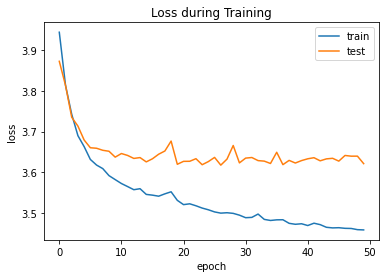

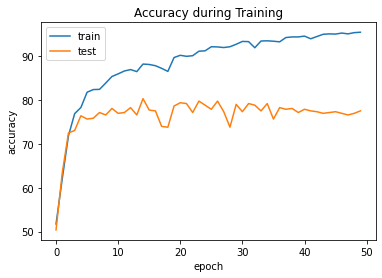

In [21]:
model, loss_train, loss_valid, acc_train, acc_valid = train_model(model, train_loader, test_loader, 50, criterion, optimizer, 10)

### Model 2

Do the exact same steps as before but add more "runs". In the previous data, we used track 3, 6 and 7 which corresponds to left and right fists. Here we select the same runs and add 10, 11 and 14, which corresponds to "imagined" closing and opening of both feet.

In [ ]:
subjects = [i for i in range(1, 61)]
runs = [3,6,7,10,11,14] # select fists and feet
eeg = motorImagery(dataset_path, subjects, runs)
X, y = eeg.get_X_y(channel_selection=False)

# ## This is to prepare CNN data form (if implementing RNN, deactivate this cell)
X = X[:, np.newaxis,:,:]# X = X_norm
X = X *10000
X[0]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

train_loader = Xy_dataloader(X_train, y_train, 64)
test_loader = Xy_dataloader(X_test, y_test, 64)

model_3 = ConvNet3(1, 2).to(device)
optimizer = optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epoch 50/50 train loss: 3.54276 train acc: 87.22119140625 validation loss: 3.68956 validation acc: 71.95913696289062


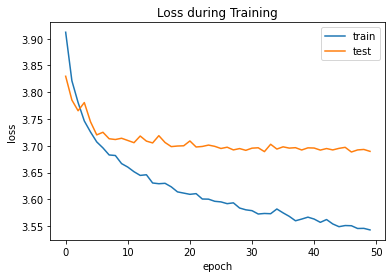

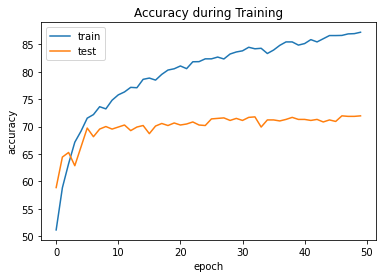

In [23]:
model_3, loss_train, loss_valid, acc_train, acc_valid = train_model(model_3, train_loader, test_loader, 50, criterion, optimizer, 10)

## 5. Model Evaluation

In [24]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
    
    x = x.to(device)
            
    out = model(x).to('cpu')
    
    pred = torch.max(out, 1)[1].numpy()
    
    return pred

In [25]:
y_pred = predict_model(model, X_test)

RuntimeError: CUDA out of memory. Tried to allocate 6.29 GiB (GPU 0; 8.00 GiB total capacity; 322.45 MiB already allocated; 5.64 GiB free; 476.00 MiB reserved in total by PyTorch)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))